# Predict Probabiity of Admission Using Minimal Data 

What if a hospital has only minimal data available in real-time. Is it still feasible to make predictions?

Here I report the results of using a very limited dataset.

I have taken data elements from two datasets used in management of emergency care nationally. 

* The [Emergency Care Data Set](https://www.datadictionary.nhs.uk/data_sets/clinical_data_sets/ecds_v4/emergency_care_data_set_version_4.html) (ECDS), a standardised national dataset that sends information collected during an ED visit to NHS England on a daily basis.
* The [Operational Pressures Escalation Levels](https://www.england.nhs.uk/long-read/integrated-opel-framework-2024-to-2026/) (OPEL) Framework, a national framework used by the NHS to track daily operational pressures. OPEL data is not reported at patient level, but it does require preparation of metrics based on patient-level data (eg number in ED)

### Data elements found in ECDS

I picked a subset of variables from the UCLH dataaset which have reasonable completion rates in ECDS, according to information shared with me by NHS England. These are listed below with a link to the NHS Data Dictionary 

| Data Element | NHS Data Dictionary Link |
|------------|-------------------|
| Activity start date and time | https://www.datadictionary.nhs.uk/data_elements/urgent_and_emergency_care_activity_start_date_and_time.html |
| Activity end date and time | https://www.datadictionary.nhs.uk/data_elements/urgent_and_emergency_care_activity_end_date_and_time.html |
| Arrival mode | https://www.datadictionary.nhs.uk/data_elements/urgent_and_emergency_care_arrival_mode__snomed_ct_.html |
| Age | https://www.datadictionary.nhs.uk/data_elements/age_at_cds_activity_date.html |
| Gender¹ | https://www.datadictionary.nhs.uk/data_elements/emergency_care_expected_date.html |
| Acuity² | https://www.datadictionary.nhs.uk/data_elements/urgent_and_emergency_care_acuity__snomed_ct_.html |
| Discharge status | https://www.datadictionary.nhs.uk/data_elements/urgent_and_emergency_care_discharge_status__snomed_ct_.html |

¹ Regarding gender, there are two fields in the NHSE data dictionary: stated gender and phenotypic sex. My data is slighly different; I have recorded categories of male or female.  
² Regarding acuity, I have used Manchester Triage Scores. These may not directly map to the Acuity levels in ECDS. 

### Data elements found in OPEL 

OPEL requires providers to report the following parameters about their current Emergency Department (ED):  

1.	Average ambulance handover since midnight (minutes)
2.	Current 4-hour ED performance percentage (percentage)
3.	Current ED majors and resus occupancy (percentage)
4.	Current median time to treatment since midnight (minutes)
5.	Patients in ED over 12 hours (percentage)
6.	Patients in ED referred to service (percentage)

I have used the following elements in my dataset:

| Data Element | Use in OPEL |
|------------|-------------------|
| Patient in Majors | Numerator of current ED majors and resus occupancy (percentage)|
| Patient in Resus | Numerator of current ED majors and resus occupancy (percentage)|
| Length of stay | Patients in ED over 12 hours (percentage)|
| Has consult request | Patients in ED referred to service (percentage)|

This notebook shows the results of modelling using only the elements covered above. 




## Set up the notebook environment

In [2]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [3]:
from patientflow.load import set_project_root
project_root = set_project_root()

Inferred project root: /Users/zellaking/Repos/patientflow


## Load parameters and set file paths, and load data

In [4]:
import pandas as pd
from patientflow.load import load_data
from patientflow.load import set_file_paths

# set file paths
data_folder_name = 'data-public'
data_file_path = project_root / data_folder_name

data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
    project_root, 
    data_folder_name=data_folder_name,
    config_file = 'config.yaml')

# load data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

# load params
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]


Configuration will be loaded from: /Users/zellaking/Repos/patientflow/config.yaml
Data files will be loaded from: /Users/zellaking/Repos/patientflow/data-public
Trained models will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public
Images will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public/media


## Train models 

In [5]:
# Reduce data to minimum
from datetime import timedelta

minimum_data_cols = ['snapshot_date', 'prediction_time', 'visit_number', 'elapsed_los', 'latest_obs_manchester_triage_acuity',
       'sex', 'age_group', 'arrival_method', 'has_consultation', 'current_location_type', 'is_admitted']

ed_visits_minimal= ed_visits[minimum_data_cols].copy()

# create majors resus column
ed_visits_minimal['is_majors_resus'] = ed_visits_minimal['current_location_type'].isin(['majors', 'resus'])

# create over 12 hours column
ed_visits_minimal.loc[:, 'over_12_hours'] = ed_visits_minimal['elapsed_los'] > timedelta(hours=12).total_seconds()

# drop other columns
ed_visits_minimal.drop(columns=['current_location_type', 'elapsed_los'], inplace=True)

# Save ed_visits_minimal to CSV
ed_visits_minimal.to_csv(data_file_path / 'ed_visits_minimal.csv')


In [50]:
from patientflow.prepare import create_temporal_splits

train_visits, valid_visits, test_visits = create_temporal_splits(
    ed_visits_minimal,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date",
)

_, _, test_visits_full = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date",
)

Split sizes: [53801, 6519, 19494]
Split sizes: [53801, 6519, 19494]


In [7]:
ordinal_mappings = {

    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],

    }
exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number']

In [10]:
from datetime import datetime

# Create metadata dictionary
train_dttm = datetime.now().strftime("%Y-%m-%d-%H-%M")
model_metadata = {
    "train_dttm": train_dttm,
}

# grid for hyperparameter tuning
grid = {
    'n_estimators':[30, 40, 50],
    'subsample':[0.7,0.8,0.9],
    'colsample_bytree': [0.7,0.8,0.9]
}

# # minimal grid for expediency
# grid = {"n_estimators": [30], "subsample": [0.7], "colsample_bytree": [0.7]}



In [11]:
# train admissions model
from patientflow.train.classifiers import train_multiple_classifiers

prediction_times = ed_visits.prediction_time.unique()

model_name = "admissions_minimal_balanced_calibrated"
model_metadata, trained_models = train_multiple_classifiers(
    train_visits=train_visits,
    valid_visits=valid_visits,
    test_visits=test_visits,
    grid=grid,
    exclude_from_training_data=exclude_from_training_data,
    ordinal_mappings=ordinal_mappings,
    prediction_times=prediction_times,
    model_name=model_name,
    model_metadata=model_metadata,
    calibrate_probabilities=True,
    use_balanced_training=True,
    visit_col='visit_number' 
)

# save models and metadata
from patientflow.train.utils import save_model

save_model(trained_models, model_name, model_file_path)

print(f"Models have been saved to {model_file_path}")


Processing: (12, 0)

Processing: (15, 30)

Processing: (6, 0)

Processing: (9, 30)

Processing: (22, 0)
Models have been saved to /Users/zellaking/Repos/patientflow/trained-models/public


## Compare miminal model with full model


How does this minimal model compare with a full model? 

To answer this question, I first use some standard Machine Learning metrics to see how consistent model's predictions were for each patient with the numbers actually admitted. 

I'm dealing with what is known as an 'imbalanced' class problem in Machine Learning. The Area under the Precision-Recall Curve (AUPRC) is informative for imbalanced datasets. It shows how well the model identifies true positive cases (admissions) while minimizing false positives. The AUPRC score should be higher than the proportion of admissions in the dataset. 

In my case, a higher AUPRC indicates that the model can better identify patients who will need admission while minimising any excess effort to prepare beds for patients who will not be admitted. 

From the output below, both the minimal model and the full model improve over the baseline class balance, but the full model does better. Using a minimal dataset mean less good predictions, but only to a marginal extent.


In [17]:
from patientflow.viz.model_comparison import plot_model_comparisons, load_model_results, print_model_results


prediction_times = ed_visits.prediction_time.unique()
models = {
    'admissions_minimal_balanced_calibrated': 'minimal_model_metadata.json',
    'admissions_balanced_calibrated': 'model_metadata_balanced_calibrated.json'
}
results = load_model_results(model_file_path, prediction_times, models)
print_model_results(results, metrics_keys=["original_positive_rate", "test_auprc"])




Results for admissions_minimal_balanced_calibrated model

Model: admissions_minimal_balanced_calibrated_0600; class balance: 0.172; auprc: 0.412 

Model: admissions_minimal_balanced_calibrated_0930; class balance: 0.131; auprc: 0.300 

Model: admissions_minimal_balanced_calibrated_1200; class balance: 0.124; auprc: 0.327 

Model: admissions_minimal_balanced_calibrated_1530; class balance: 0.155; auprc: 0.383 

Model: admissions_minimal_balanced_calibrated_2200; class balance: 0.165; auprc: 0.528 



Results for admissions_balanced_calibrated model

Model: admissions_balanced_calibrated_0600; class balance: 0.172; auprc: 0.476 

Model: admissions_balanced_calibrated_0930; class balance: 0.131; auprc: 0.398 

Model: admissions_balanced_calibrated_1200; class balance: 0.124; auprc: 0.422 

Model: admissions_balanced_calibrated_1530; class balance: 0.155; auprc: 0.470 

Model: admissions_balanced_calibrated_2200; class balance: 0.165; auprc: 0.587 




The AUPRC ranges printed above represent an improvement over the positive class proportion. 

Here, the XGBoost classifier models used have been optimised to minimize log loss (also known as cross-entropy loss), as our primary goal is to obtain well-calibrated probability estimates rather than binary classifications. Log loss is particularly suitable for this purpose as it heavily penalizes predictions that are both wrong and made with high confidence, encouraging the model to produce well-calibrated probability estimates. For example, predicting a 90% chance of admission for a patient who is ultimately discharged would incur a much higher penalty than predicting a 60% chance. A focus on probability calibration through log loss minimization provides more informative outputs than simple binary predictions, giving us richer understanding of the model's certainty about each prediction. 

To look at the model's calibration, let's compare both the minimal and the full model


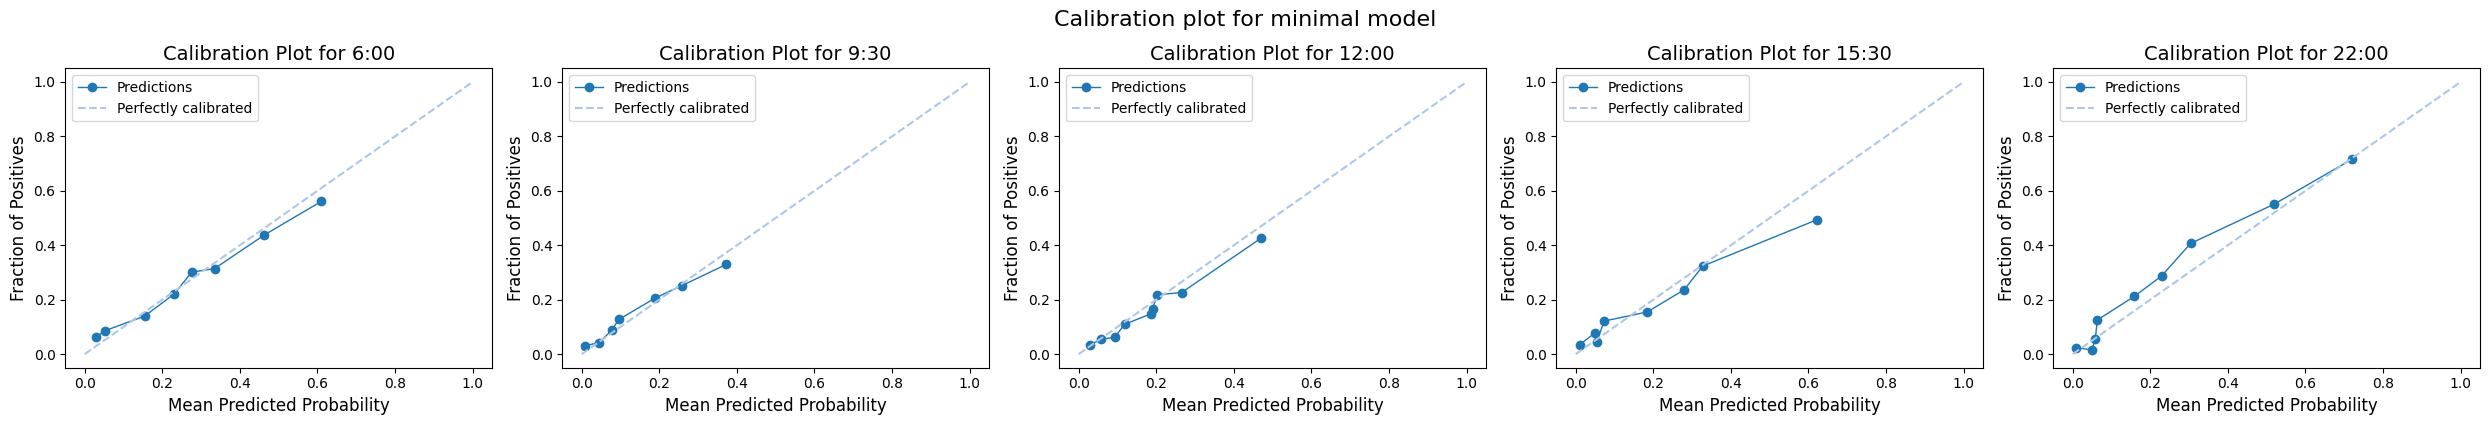

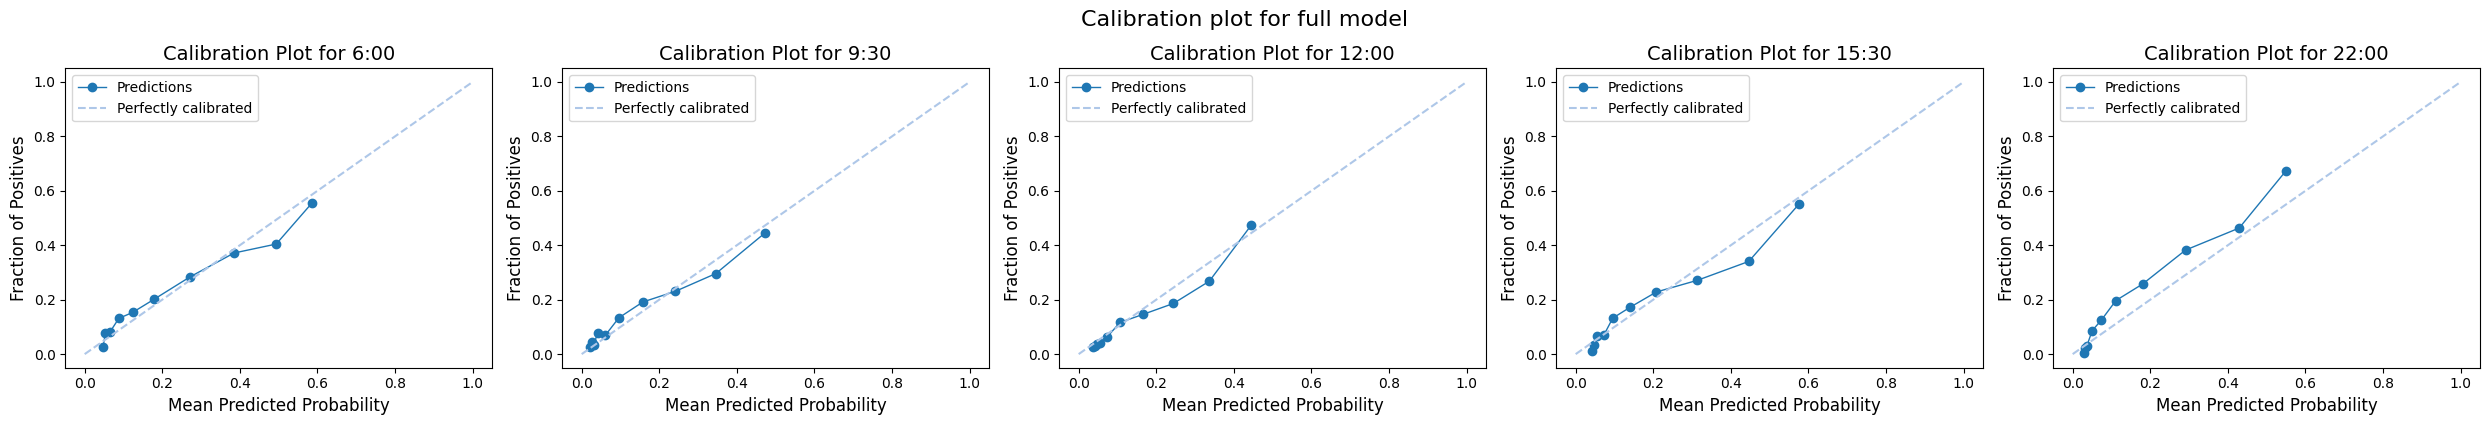

In [ ]:
from patientflow.viz.calibration_plot import plot_calibration
from patientflow.load import load_saved_model, get_model_key

exclude_from_training_data = [ 'snapshot_date', 'prediction_time','consultation_sequence', 'visit_number', 'specialty', 'final_sequence', 'training_validation_test']

# calibration plot for minimal model
plot_calibration(
    prediction_times,
    media_file_path,
    trained_models,
    test_visits,
    exclude_from_training_data,
    strategy="quantile",
    model_group_name='admissions_minimal_balanced_calibrated',
    suptitle="Calibration plot for minimal model"
)

# calibration plot for full model
plot_calibration(
    prediction_times,
    media_file_path,
    trained_models=None,
    test_visits=test_visits_full,
    exclude_from_training_data=exclude_from_training_data,
    strategy="quantile",
    model_group_name='admissions_balanced_calibrated',
    suptitle="Calibration plot for full model",
    model_file_path=model_file_path
)



## Evaluation predictions of bed numbers

In [ ]:
### TO FOLLOW




## Conclusion

I have demonstrated here that a minimal dataset, using a small number of data points that NHS trusts would be collecting routinely, could be used to predict emergency demand for beds. 

I have assumed that a hospital can access this data in real-time, and has a way to run predictive models using those data. 

### Would hospitals really be able to run models using these data in real-time?

The answer depends on the each provider's own data infrastructure. Such data are certainly captured in EHR, PAS or other systems, and they are sent to the SUS+ with some degree of lag. We understand from NHSE that some hospitals send updates with lags of a day or two, and/or send Type 1 acuity (the most acute) daily but not others.  

NHS England has invested in a Federated Data Platform, so there is the possibility that such models could be run on that platforn. 

